<a href="https://colab.research.google.com/github/Arminxrr/Backend/blob/main/datapp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
rabieelkharoua_predict_online_gaming_behavior_dataset_path = kagglehub.dataset_download('rabieelkharoua/predict-online-gaming-behavior-dataset')

print('Data source import complete.')


100%|██████████| 904k/904k [00:00<00:00, 41.3MB/s]

Extracting files...
Data source import complete.


In [ ]:
%pip install category_encoders
%pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 11.9 MB/s eta 0:00:00


In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import seaborn as sns
import matplotlib.pyplot as plt

from category_encoders import TargetEncoder
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix

# EDA

## Let's firstly take a look at our dataset

In [ ]:
import os

# Use the path obtained from kagglehub.dataset_download
gaming_data_path = os.path.join(rabieelkharoua_predict_online_gaming_behavior_dataset_path, 'online_gaming_behavior_dataset.csv')
gaming_data = pd.read_csv(gaming_data_path)

# --- 1. Basic Info ---
print(gaming_data.info())
print(gaming_data.describe())
print("Missing values:\n", gaming_data.isnull().sum())
print("Duplicated rows:", gaming_data.duplicated().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40034 entries, 0 to 40033
Data columns (total 13 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   PlayerID                   40034 non-null  int64  
 1   Age                        40034 non-null  int64  
 2   Gender                     40034 non-null  object 
 3   Location                   40034 non-null  object 
 4   GameGenre                  40034 non-null  object 
 5   PlayTimeHours              40034 non-null  float64
 6   InGamePurchases            40034 non-null  int64  
 7   GameDifficulty             40034 non-null  object 
 8   SessionsPerWeek            40034 non-null  int64  
 9   AvgSessionDurationMinutes  40034 non-null  int64  
 10  PlayerLevel                40034 non-null  int64  
 11  AchievementsUnlocked       40034 non-null  int64  
 12  EngagementLevel            40034 non-null  object 
dtypes: float64(1), int64(7), object(5)
memory usag

### - As we can see, we have 13 columns that contain information about players such as their age, genre of a game they play, their level etc
### - Moreover, our data doesn't contain any null values

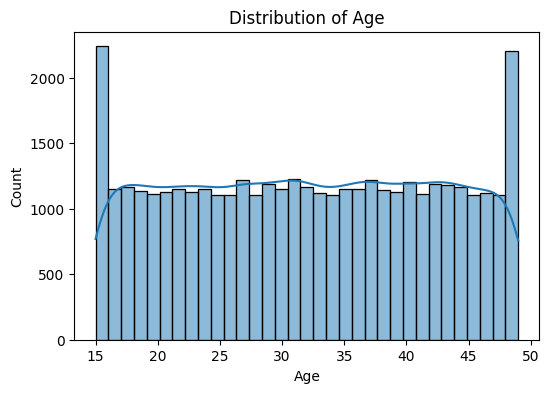

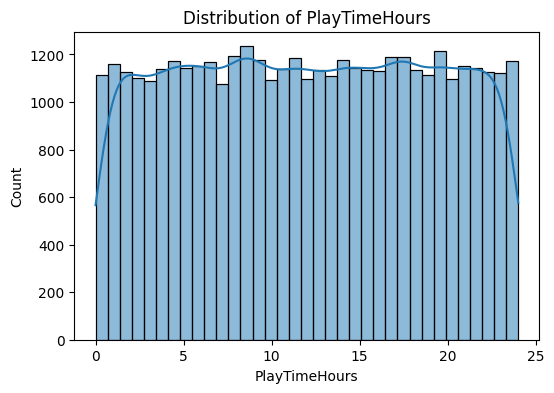

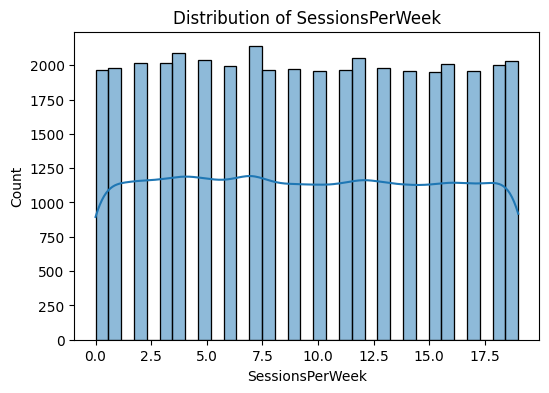

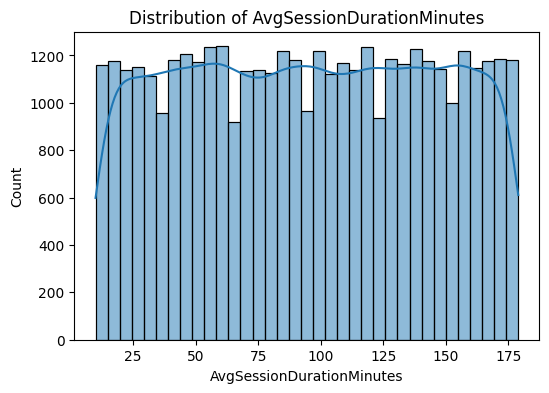

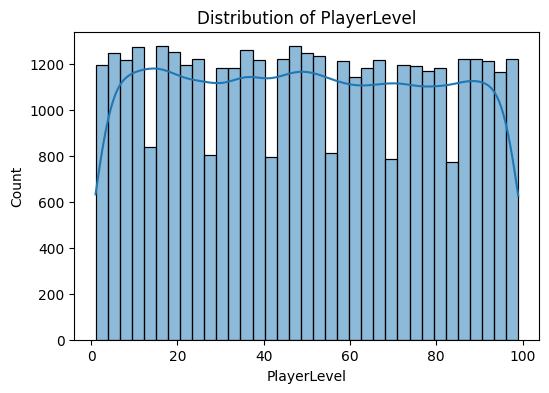

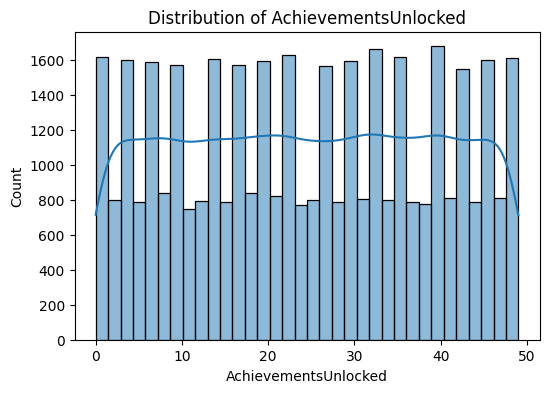

In [ ]:
# --- 2. Numeric Distributions ---
num_cols = ['Age', 'PlayTimeHours', 'SessionsPerWeek', 'AvgSessionDurationMinutes', 'PlayerLevel', 'AchievementsUnlocked']
for col in num_cols:
    plt.figure(figsize=(6, 4))
    sns.histplot(gaming_data[col], kde=True)
    plt.title(f'Distribution of {col}')
    plt.show()

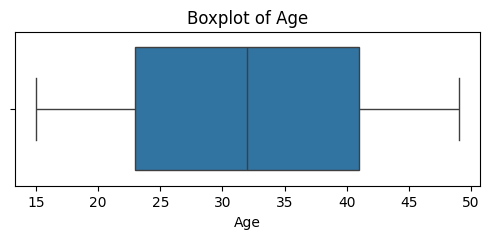

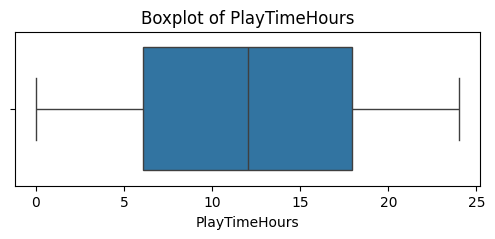

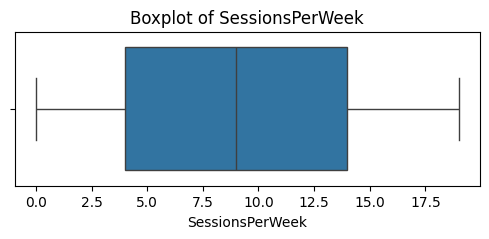

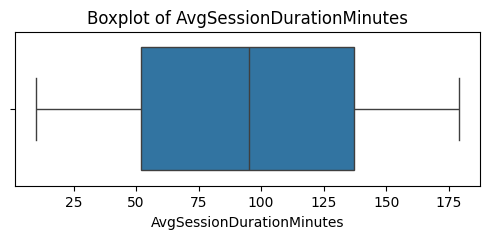

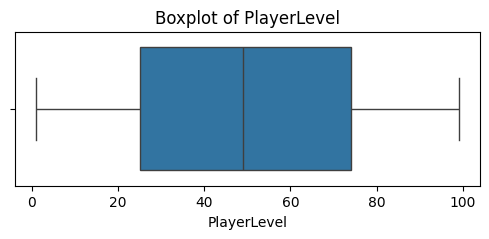

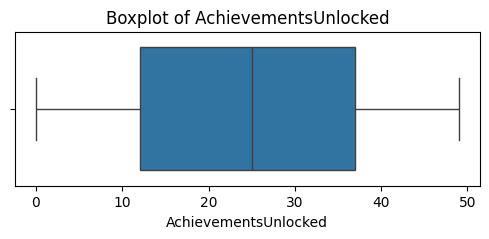

In [ ]:
# --- Boxplots ---
for col in num_cols:
    plt.figure(figsize=(6, 2))
    sns.boxplot(x=gaming_data[col])
    plt.title(f'Boxplot of {col}')
    plt.show()

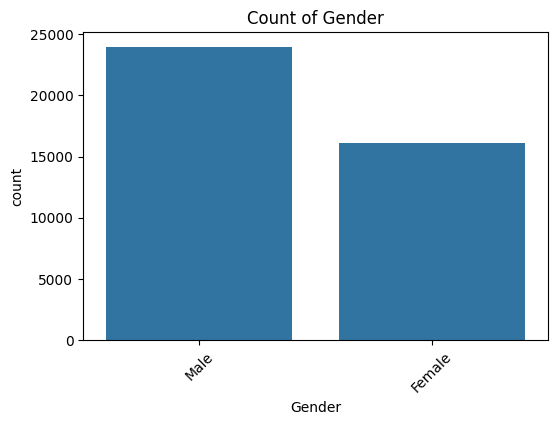

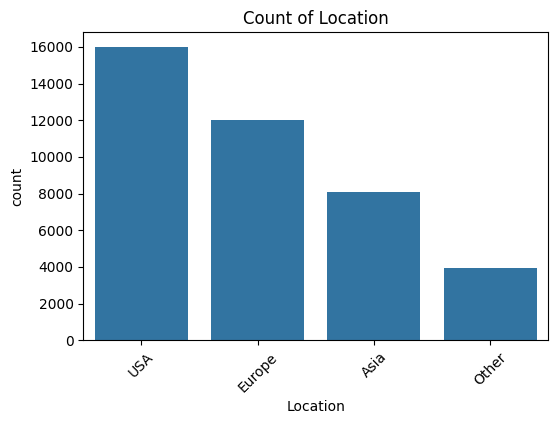

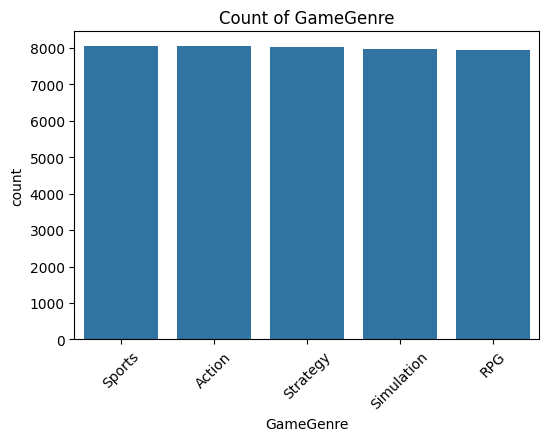

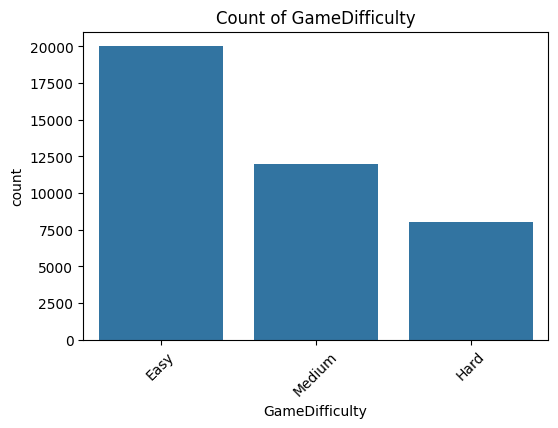

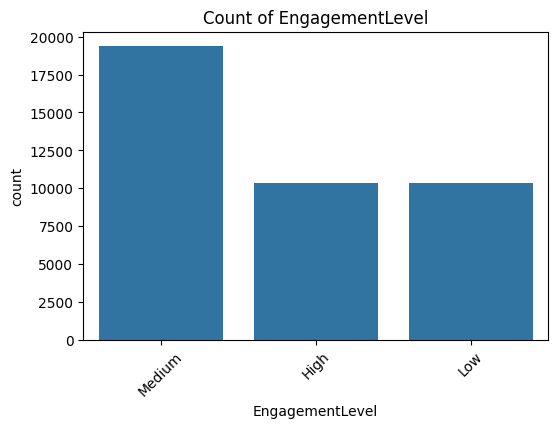

In [ ]:
# --- 3. Categorical Counts ---
cat_cols = ['Gender', 'Location', 'GameGenre', 'GameDifficulty', 'EngagementLevel']
for col in cat_cols:
    plt.figure(figsize=(6, 4))
    sns.countplot(data=gaming_data, x=col, order=gaming_data[col].value_counts().index)
    plt.title(f'Count of {col}')
    plt.xticks(rotation=45)
    plt.show()

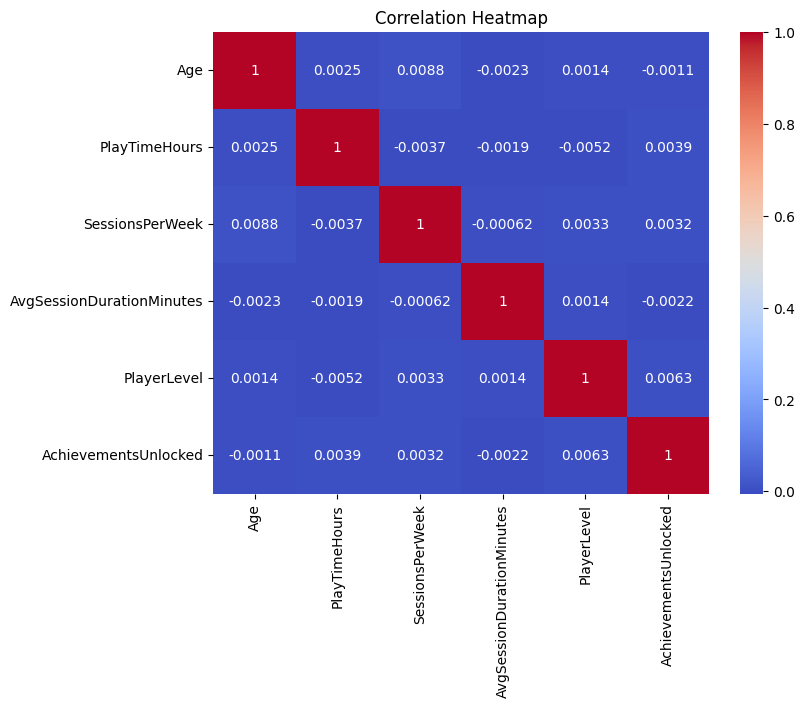

In [ ]:
# --- 4. Correlation Heatmap ---
corr = gaming_data[num_cols].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

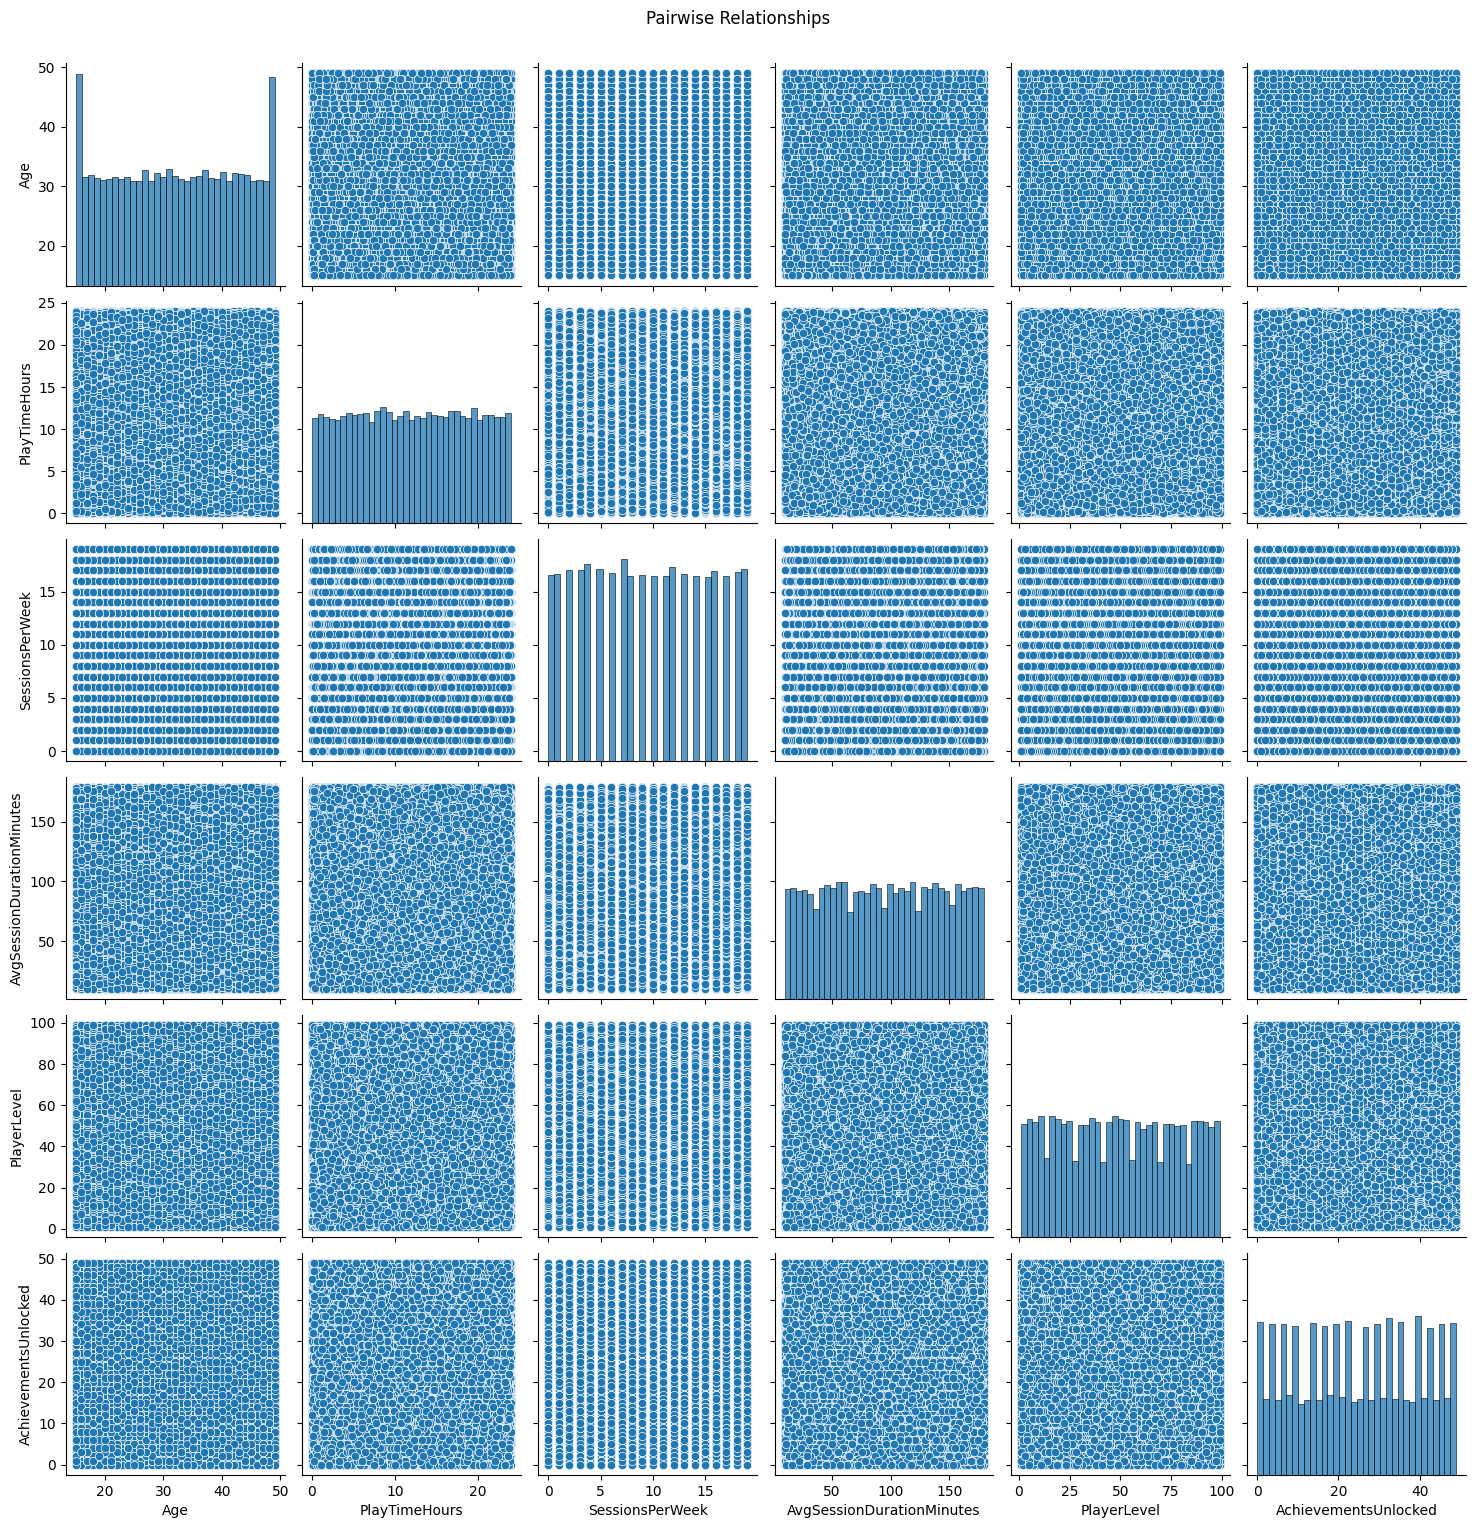

In [ ]:
# --- 5. Pairwise Relationships ---
sns.pairplot(gaming_data[num_cols])
plt.suptitle('Pairwise Relationships', y=1.02)
plt.show()

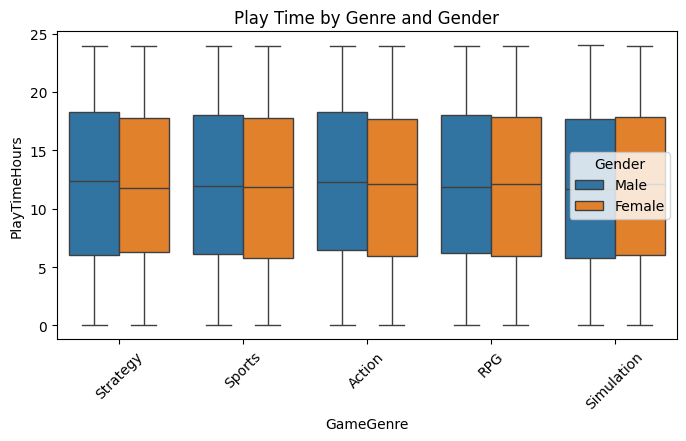

In [ ]:
# --- 6. PlayTime by Genre and Gender ---
plt.figure(figsize=(8, 4))
sns.boxplot(data=gaming_data, x='GameGenre', y='PlayTimeHours', hue='Gender')
plt.title('Play Time by Genre and Gender')
plt.xticks(rotation=45)
plt.show()

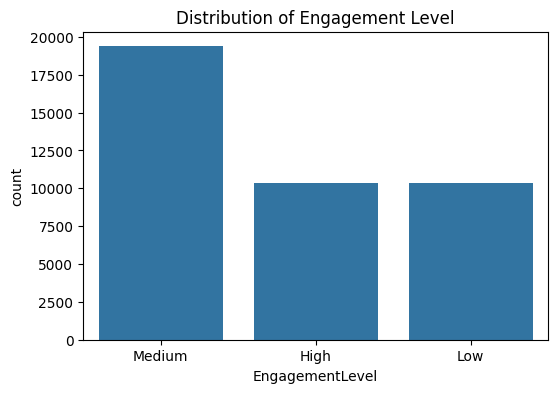

In [ ]:
# --- 7. Engagement Level Analysis ---
plt.figure(figsize=(6, 4))
sns.countplot(data=gaming_data, x='EngagementLevel')
plt.title('Distribution of Engagement Level')
plt.show()

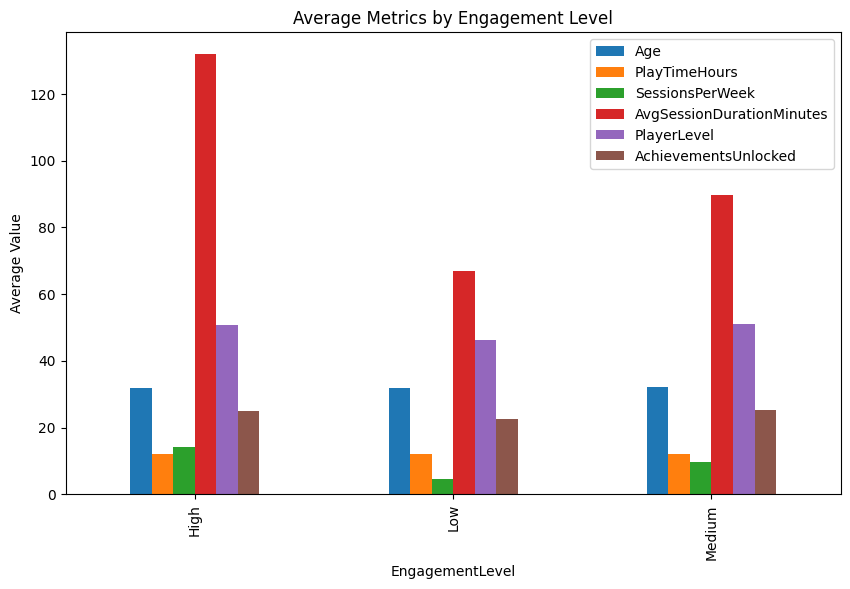

In [ ]:
# Grouped mean plots
gaming_data.groupby('EngagementLevel')[num_cols].mean().plot(kind='bar', figsize=(10, 6), title='Average Metrics by Engagement Level')
plt.ylabel('Average Value')
plt.show()

## As we can see,  most of the characteristics are more or less equal in different engagement level, but there is clear difference for average session duration and number of sessions per week.
## This makes sense: the more sessions you have, and the longer sessions are - the higher engagement level is

# Data preparation

In [ ]:
# The column 'PlayerID' is redundant as it contains no useful insights whatsoever, so we will drop it
# Dropping unnecessary column "PlayerID"
gaming_data = gaming_data.drop(axis=1, columns='PlayerID')

In [ ]:
display(gaming_data.head())

,Age,Location,GameGenre,PlayTimeHours,InGamePurchases,GameDifficulty,SessionsPerWeek,AvgSessionDurationMinutes,PlayerLevel,AchievementsUnlocked,EngagementLevel,Gender_Female,Gender_Male
0,43,Other,Strategy,16.271119,0,Medium,6,108,79,25,Medium,False,True
1,29,USA,Strategy,5.525961,0,Medium,5,144,11,10,Medium,True,False
2,22,USA,Sports,8.223755,0,Easy,16,142,35,41,High,True,False
3,35,USA,Action,5.265351,1,Easy,9,85,57,47,Medium,False,True
4,33,Europe,Action,15.531945,0,Medium,2,131,95,37,Medium,False,True


In [ ]:
# One-hot encoding "Gender" column
gaming_data = pd.get_dummies(gaming_data, columns=['Gender'])

In [ ]:
display(gaming_data.head())

,Age,Location,GameGenre,PlayTimeHours,InGamePurchases,GameDifficulty,SessionsPerWeek,AvgSessionDurationMinutes,PlayerLevel,AchievementsUnlocked,EngagementLevel,Gender_Female,Gender_Male
0,43,Other,Strategy,16.271119,0,Medium,6,108,79,25,Medium,False,True
1,29,USA,Strategy,5.525961,0,Medium,5,144,11,10,Medium,True,False
2,22,USA,Sports,8.223755,0,Easy,16,142,35,41,High,True,False
3,35,USA,Action,5.265351,1,Easy,9,85,57,47,Medium,False,True
4,33,Europe,Action,15.531945,0,Medium,2,131,95,37,Medium,False,True


In [ ]:
# Encoding "Game Difficulty" column
replace_diff = {
    'Easy': 0,
    'Medium': 1,
    'Hard': 2
}

gaming_data['GameDifficulty'] = gaming_data['GameDifficulty'].replace(replace_diff)

/tmp/ipython-input-151572864.py:8: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  gaming_data['GameDifficulty'] = gaming_data['GameDifficulty'].replace(replace_diff)


In [ ]:
display(gaming_data.head())

,Age,Location,GameGenre,PlayTimeHours,InGamePurchases,GameDifficulty,SessionsPerWeek,AvgSessionDurationMinutes,PlayerLevel,AchievementsUnlocked,EngagementLevel,Gender_Female,Gender_Male
0,43,Other,Strategy,16.271119,0,1,6,108,79,25,Medium,False,True
1,29,USA,Strategy,5.525961,0,1,5,144,11,10,Medium,True,False
2,22,USA,Sports,8.223755,0,0,16,142,35,41,High,True,False
3,35,USA,Action,5.265351,1,0,9,85,57,47,Medium,False,True
4,33,Europe,Action,15.531945,0,1,2,131,95,37,Medium,False,True


In [ ]:
# Manually map EngagementLevel to custom numeric values
level_map = {'Low': 0, 'Medium': 1, 'High': 2}
gaming_data['EngagementLevel_encoded'] = gaming_data['EngagementLevel'].map(level_map)

# Initialize the target encoder and cross-validation splitter
encoder = TargetEncoder(cols=['GameGenre', 'Location'])
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Create empty columns to store the encoded values
gaming_data['genre_encoded'] = 0.0
gaming_data['location_encoded'] = 0.0

# Cross-validation loop
for train_idx, val_idx in kf.split(gaming_data):
    # Split the data into training and validation sets
    train_df = gaming_data.iloc[train_idx]
    val_df = gaming_data.iloc[val_idx]

    # Fit the encoder only on the training part
    encoder.fit(train_df[['GameGenre', 'Location']], train_df['EngagementLevel_encoded'])

    # Transform the validation part using the fitted encoder
    transformed = encoder.transform(val_df[['GameGenre', 'Location']])

    # Save the transformed values back into the main dataframe
    gaming_data.loc[val_idx, 'genre_encoded'] = transformed['GameGenre'].values
    gaming_data.loc[val_idx, 'location_encoded'] = transformed['Location'].values

# Dropping initial columns
gaming_data = gaming_data.drop(axis=1, columns=['Location', 'GameGenre', 'EngagementLevel'])

In [ ]:
display(gaming_data.head())

,Age,PlayTimeHours,InGamePurchases,GameDifficulty,SessionsPerWeek,AvgSessionDurationMinutes,PlayerLevel,AchievementsUnlocked,Gender_Female,Gender_Male,EngagementLevel_encoded,genre_encoded,location_encoded
0,43,16.271119,0,1,6,108,79,25,False,True,1,1.006721,0.983355
1,29,5.525961,0,1,5,144,11,10,True,False,1,1.009230,1.002418
2,22,8.223755,0,0,16,142,35,41,True,False,2,0.995960,1.004068
3,35,5.265351,1,0,9,85,57,47,False,True,1,1.006110,1.005450
4,33,15.531945,0,1,2,131,95,37,False,True,1,0.991260,1.000313


Balanced Data Info:
<class 'pandas.core.frame.DataFrame'>
Index: 30984 entries, 5 to 19031
Data columns (total 13 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Age                        30984 non-null  int64  
 1   PlayTimeHours              30984 non-null  float64
 2   InGamePurchases            30984 non-null  int64  
 3   GameDifficulty             30984 non-null  int64  
 4   SessionsPerWeek            30984 non-null  int64  
 5   AvgSessionDurationMinutes  30984 non-null  int64  
 6   PlayerLevel                30984 non-null  int64  
 7   AchievementsUnlocked       30984 non-null  int64  
 8   Gender_Female              30984 non-null  bool   
 9   Gender_Male                30984 non-null  bool   
 10  EngagementLevel_encoded    30984 non-null  int64  
 11  genre_encoded              30984 non-null  float64
 12  location_encoded           30984 non-null  float64
dtypes: bool(2), float64(3), int64(8

,Age,PlayTimeHours,InGamePurchases,GameDifficulty,SessionsPerWeek,AvgSessionDurationMinutes,PlayerLevel,AchievementsUnlocked,Gender_Female,Gender_Male,EngagementLevel_encoded,genre_encoded,location_encoded
5,37,20.561855,0,0,2,81,74,22,False,True,0,0.981323,0.991584
6,25,9.752716,0,2,1,50,13,2,False,True,0,1.003422,0.997886
13,38,8.701959,0,0,0,156,33,47,True,False,0,1.009230,1.002418
14,44,17.975200,0,0,8,41,98,1,False,True,0,1.006903,1.004068
17,47,17.272113,0,1,2,131,13,9,False,True,0,0.982244,0.997886


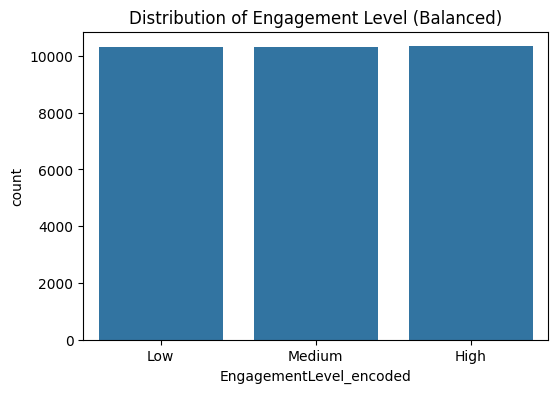


Balanced data exported to 'online_gaming_behavior_balanced.csv'


In [ ]:
from sklearn.utils import resample

# Separate classes
df_low = gaming_data[gaming_data['EngagementLevel_encoded'] == 0]
df_high = gaming_data[gaming_data['EngagementLevel_encoded'] == 2]
df_medium = gaming_data[gaming_data['EngagementLevel_encoded'] == 1]

# Find the minimum number of samples among the classes
min_samples = min(len(df_low), len(df_high))

# Downsample the majority class ('Medium')
df_medium_downsampled = resample(df_medium,
                                 replace=False,    # sample without replacement
                                 n_samples=min_samples, # to match the number of samples in the minority classes
                                 random_state=42) # reproducible results

# Combine the downsampled majority class with the minority classes
gaming_data_balanced = pd.concat([df_low, df_high, df_medium_downsampled])

# Display info, head, and bar chart for the balanced data
print("Balanced Data Info:")
print(gaming_data_balanced.info())
print("\nBalanced Data Head:")
display(gaming_data_balanced.head())

plt.figure(figsize=(6, 4))
sns.countplot(data=gaming_data_balanced, x='EngagementLevel_encoded')
plt.title('Distribution of Engagement Level (Balanced)')
plt.xticks(ticks=[0, 1, 2], labels=['Low', 'Medium', 'High'])
plt.show()

# Export the cleaned data to a CSV file
gaming_data_balanced.to_csv('online_gaming_behavior_balanced.csv', index=False)
print("\nBalanced data exported to 'online_gaming_behavior_balanced.csv'")

In [ ]:
from sklearn.model_selection import train_test_split

# Split the balanced data into modeling and unseen data
data_modeling, unseen_data = train_test_split(gaming_data_balanced, test_size=0.2, random_state=42, stratify=gaming_data_balanced['EngagementLevel_encoded'])

# Display info and head for data_modeling
print("Data Modeling Info:")
print(data_modeling.info())
print("\nData Modeling Head:")
display(data_modeling.head())

# Display info and head for unseen_data
print("\nUnseen Data Info:")
print(unseen_data.info())
print("\nUnseen Data Head:")
display(unseen_data.head())

# Save the split data to CSV files
data_modeling.to_csv('online_gaming_behavior_modeling.csv', index=False)
unseen_data.to_csv('online_gaming_behavior_unseen.csv', index=False)

print("\nData split and saved to 'online_gaming_behavior_modeling.csv' and 'online_gaming_behavior_unseen.csv'")

Data Modeling Info:
<class 'pandas.core.frame.DataFrame'>
Index: 24787 entries, 8793 to 39142
Data columns (total 13 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Age                        24787 non-null  int64  
 1   PlayTimeHours              24787 non-null  float64
 2   InGamePurchases            24787 non-null  int64  
 3   GameDifficulty             24787 non-null  int64  
 4   SessionsPerWeek            24787 non-null  int64  
 5   AvgSessionDurationMinutes  24787 non-null  int64  
 6   PlayerLevel                24787 non-null  int64  
 7   AchievementsUnlocked       24787 non-null  int64  
 8   Gender_Female              24787 non-null  bool   
 9   Gender_Male                24787 non-null  bool   
 10  EngagementLevel_encoded    24787 non-null  int64  
 11  genre_encoded              24787 non-null  float64
 12  location_encoded           24787 non-null  float64
dtypes: bool(2), float64(3), int6

,Age,PlayTimeHours,InGamePurchases,GameDifficulty,SessionsPerWeek,AvgSessionDurationMinutes,PlayerLevel,AchievementsUnlocked,Gender_Female,Gender_Male,EngagementLevel_encoded,genre_encoded,location_encoded
8793,35,8.072180,1,0,10,172,54,39,True,False,2,1.016471,0.988517
12710,39,10.115493,0,0,9,162,11,16,False,True,0,1.009230,0.998417
18382,44,1.969392,1,2,6,15,69,6,True,False,2,1.006110,0.987497
16500,38,0.094283,0,1,7,56,31,5,True,False,1,1.003746,0.987497
5282,21,4.769986,0,1,9,70,10,41,True,False,1,0.982244,0.997886



Unseen Data Info:
<class 'pandas.core.frame.DataFrame'>
Index: 6197 entries, 10896 to 35356
Data columns (total 13 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Age                        6197 non-null   int64  
 1   PlayTimeHours              6197 non-null   float64
 2   InGamePurchases            6197 non-null   int64  
 3   GameDifficulty             6197 non-null   int64  
 4   SessionsPerWeek            6197 non-null   int64  
 5   AvgSessionDurationMinutes  6197 non-null   int64  
 6   PlayerLevel                6197 non-null   int64  
 7   AchievementsUnlocked       6197 non-null   int64  
 8   Gender_Female              6197 non-null   bool   
 9   Gender_Male                6197 non-null   bool   
 10  EngagementLevel_encoded    6197 non-null   int64  
 11  genre_encoded              6197 non-null   float64
 12  location_encoded           6197 non-null   float64
dtypes: bool(2), float64(3), int64

,Age,PlayTimeHours,InGamePurchases,GameDifficulty,SessionsPerWeek,AvgSessionDurationMinutes,PlayerLevel,AchievementsUnlocked,Gender_Female,Gender_Male,EngagementLevel_encoded,genre_encoded,location_encoded
10896,42,7.253669,0,2,0,153,43,1,False,True,0,0.992068,0.997886
22099,32,2.192212,0,1,3,117,27,34,True,False,1,1.006903,1.004068
15195,27,4.956419,0,0,4,60,81,11,False,True,0,1.004482,1.004068
36478,46,14.620047,1,0,16,145,69,25,False,True,2,1.009230,1.000313
16769,15,4.147244,0,0,17,111,84,17,False,True,2,1.006721,0.997886



Data split and saved to 'online_gaming_behavior_modeling.csv' and 'online_gaming_behavior_unseen.csv'


In [ ]:
from sklearn.model_selection import train_test_split

# Split data_modeling into train and test sets without separating X and y
data_modeling_train, data_modeling_test = train_test_split(data_modeling, test_size=0.2, random_state=42, stratify=data_modeling['EngagementLevel_encoded'])

# Display info and head for data_modeling_train
print("Data Modeling Train Info:")
print(data_modeling_train.info())
print("\nData Modeling Train Head:")
display(data_modeling_train.head())

# Display info and head for data_modeling_test
print("\nData Modeling Test Info:")
print(data_modeling_test.info())
print("\nData Modeling Test Head:")
display(data_modeling_test.head())

# Save the split data to CSV files
data_modeling_train.to_csv('data_modeling_train.csv', index=False)
data_modeling_test.to_csv('data_modeling_test.csv', index=False)

print("\nData split and saved to 'data_modeling_train.csv' and 'data_modeling_test.csv'")

Data Modeling Train Info:
<class 'pandas.core.frame.DataFrame'>
Index: 19829 entries, 10696 to 29341
Data columns (total 13 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Age                        19829 non-null  int64  
 1   PlayTimeHours              19829 non-null  float64
 2   InGamePurchases            19829 non-null  int64  
 3   GameDifficulty             19829 non-null  int64  
 4   SessionsPerWeek            19829 non-null  int64  
 5   AvgSessionDurationMinutes  19829 non-null  int64  
 6   PlayerLevel                19829 non-null  int64  
 7   AchievementsUnlocked       19829 non-null  int64  
 8   Gender_Female              19829 non-null  bool   
 9   Gender_Male                19829 non-null  bool   
 10  EngagementLevel_encoded    19829 non-null  int64  
 11  genre_encoded              19829 non-null  float64
 12  location_encoded           19829 non-null  float64
dtypes: bool(2), float64(3

,Age,PlayTimeHours,InGamePurchases,GameDifficulty,SessionsPerWeek,AvgSessionDurationMinutes,PlayerLevel,AchievementsUnlocked,Gender_Female,Gender_Male,EngagementLevel_encoded,genre_encoded,location_encoded
10696,20,8.135789,0,1,17,93,19,47,True,False,0,1.006721,0.991403
7187,28,15.073295,0,0,2,82,40,36,False,True,0,1.004482,0.991584
15017,29,18.951256,0,0,0,169,16,41,True,False,0,0.998748,1.000313
39520,18,17.856013,1,0,18,138,91,37,False,True,2,0.989261,1.002661
8166,26,0.357491,0,0,8,31,47,19,False,True,0,0.981323,1.004068



Data Modeling Test Info:
<class 'pandas.core.frame.DataFrame'>
Index: 4958 entries, 1092 to 39493
Data columns (total 13 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Age                        4958 non-null   int64  
 1   PlayTimeHours              4958 non-null   float64
 2   InGamePurchases            4958 non-null   int64  
 3   GameDifficulty             4958 non-null   int64  
 4   SessionsPerWeek            4958 non-null   int64  
 5   AvgSessionDurationMinutes  4958 non-null   int64  
 6   PlayerLevel                4958 non-null   int64  
 7   AchievementsUnlocked       4958 non-null   int64  
 8   Gender_Female              4958 non-null   bool   
 9   Gender_Male                4958 non-null   bool   
 10  EngagementLevel_encoded    4958 non-null   int64  
 11  genre_encoded              4958 non-null   float64
 12  location_encoded           4958 non-null   float64
dtypes: bool(2), float64(3),

,Age,PlayTimeHours,InGamePurchases,GameDifficulty,SessionsPerWeek,AvgSessionDurationMinutes,PlayerLevel,AchievementsUnlocked,Gender_Female,Gender_Male,EngagementLevel_encoded,genre_encoded,location_encoded
1092,31,6.719045,1,0,1,92,68,34,False,True,0,1.003134,1.002418
21851,41,14.858517,0,1,6,62,51,45,True,False,1,1.004482,0.991584
33521,48,20.448918,0,0,9,96,11,2,False,True,1,0.981323,1.006656
16648,15,8.088109,0,0,15,44,79,5,False,True,1,1.004482,1.004068
7572,18,6.035168,0,0,4,73,18,4,False,True,0,1.011820,0.991584



Data split and saved to 'data_modeling_train.csv' and 'data_modeling_test.csv'


### Let's try to use different models and then compare the results

In [ ]:
# Load the training and testing data from CSV files
data_modeling_train = pd.read_csv('data_modeling_train.csv')
data_modeling_test = pd.read_csv('data_modeling_test.csv')

# Define features (X) and target (y)
X_train = data_modeling_train.drop('EngagementLevel_encoded', axis=1)
y_train = data_modeling_train['EngagementLevel_encoded']

X_test = data_modeling_test.drop('EngagementLevel_encoded', axis=1)
y_test = data_modeling_test['EngagementLevel_encoded']

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (19829, 12)
y_train shape: (19829,)
X_test shape: (4958, 12)
y_test shape: (4958,)


In [ ]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier

# Model Initialization
models = {
    "Random Forest": RandomForestClassifier(random_state=42, class_weight = 'balanced'),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "LightGBM": LGBMClassifier(verbose=-1, random_state=42, class_weight = 'balanced'),
    "CatBoost": CatBoostClassifier(verbose=0, random_state=42),
    "Extra Trees": ExtraTreesClassifier(random_state=42, class_weight='balanced'),
    "Logistic Regression": LogisticRegression(random_state=42, multi_class='multinomial', solver='lbfgs'),
    "MLP Classifier": MLPClassifier(random_state=42, max_iter=1000)
}

# Display model names to confirm initialization
print("Models initialized:", list(models.keys()))

Models initialized: ['Random Forest', 'Gradient Boosting', 'LightGBM', 'CatBoost', 'Extra Trees', 'Logistic Regression', 'MLP Classifier']


Performing GridSearchCV for: Random Forest
Best parameters for Random Forest: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}

Evaluating Random Forest on Training Set:
Training Accuracy: 1.0000
Training AUC: 1.0
Classification Report for Random Forest (Training):

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      6607
           1       1.00      1.00      1.00      6607
           2       1.00      1.00      1.00      6615

    accuracy                           1.00     19829
   macro avg       1.00      1.00      1.00     19829
weighted avg       1.00      1.00      1.00     19829



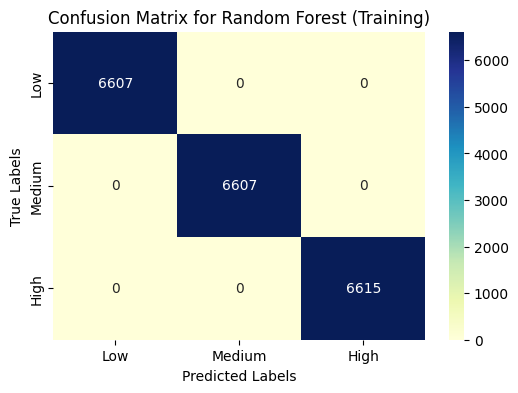


Evaluating Random Forest on Test Set:
Test Accuracy: 0.8901
Test AUC: 0.9411111263317625
Classification Report for Random Forest (Test):

              precision    recall  f1-score   support

           0       0.90      0.88      0.89      1652
           1       0.85      0.90      0.87      1652
           2       0.92      0.89      0.90      1654

    accuracy                           0.89      4958
   macro avg       0.89      0.89      0.89      4958
weighted avg       0.89      0.89      0.89      4958



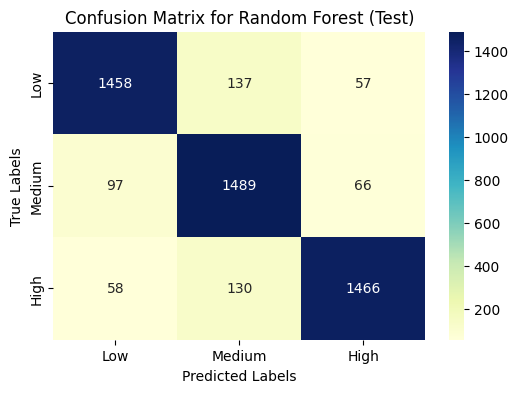

Performing GridSearchCV for: Gradient Boosting
Best parameters for Gradient Boosting: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100}

Evaluating Gradient Boosting on Training Set:
Training Accuracy: 0.9218
Training AUC: 0.9781605281198856
Classification Report for Gradient Boosting (Training):

              precision    recall  f1-score   support

           0       0.94      0.91      0.93      6607
           1       0.89      0.94      0.91      6607
           2       0.94      0.91      0.93      6615

    accuracy                           0.92     19829
   macro avg       0.92      0.92      0.92     19829
weighted avg       0.92      0.92      0.92     19829



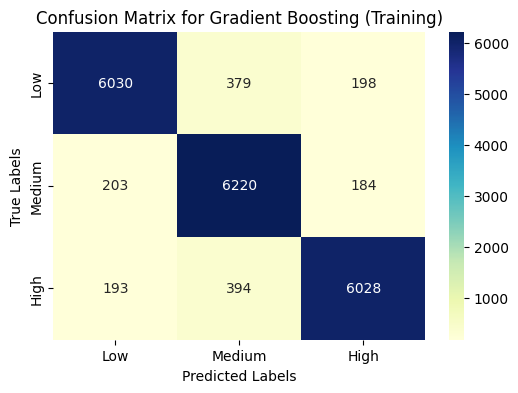


Evaluating Gradient Boosting on Test Set:
Test Accuracy: 0.8949
Test AUC: 0.9421149426184773
Classification Report for Gradient Boosting (Test):

              precision    recall  f1-score   support

           0       0.91      0.88      0.90      1652
           1       0.86      0.90      0.88      1652
           2       0.92      0.90      0.91      1654

    accuracy                           0.89      4958
   macro avg       0.90      0.89      0.90      4958
weighted avg       0.90      0.89      0.90      4958



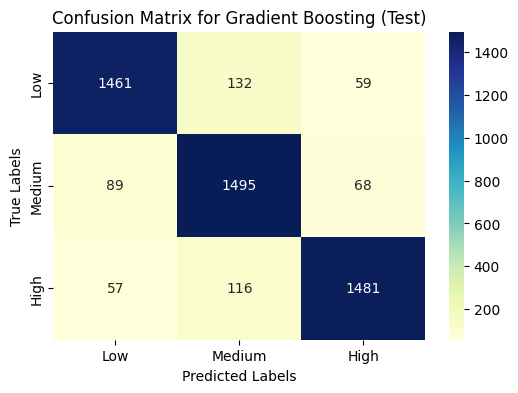

Performing GridSearchCV for: LightGBM
Best parameters for LightGBM: {'learning_rate': 0.1, 'n_estimators': 100, 'num_leaves': 62}

Evaluating LightGBM on Training Set:
Training Accuracy: 0.9429
Training AUC: 0.9957206624156129
Classification Report for LightGBM (Training):

              precision    recall  f1-score   support

           0       0.97      0.93      0.95      6607
           1       0.91      0.98      0.94      6607
           2       0.96      0.93      0.94      6615

    accuracy                           0.94     19829
   macro avg       0.94      0.94      0.94     19829
weighted avg       0.94      0.94      0.94     19829



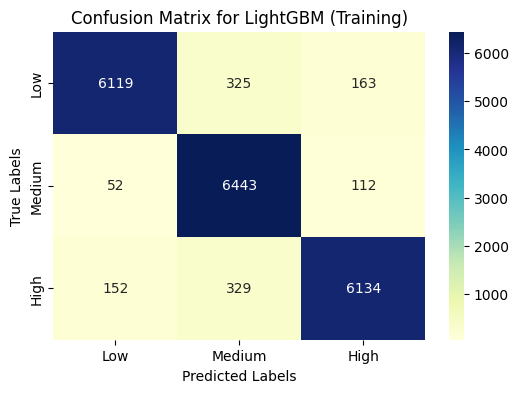


Evaluating LightGBM on Test Set:
Test Accuracy: 0.9016
Test AUC: 0.9418613225711566
Classification Report for LightGBM (Test):

              precision    recall  f1-score   support

           0       0.92      0.89      0.90      1652
           1       0.86      0.92      0.89      1652
           2       0.93      0.90      0.91      1654

    accuracy                           0.90      4958
   macro avg       0.90      0.90      0.90      4958
weighted avg       0.90      0.90      0.90      4958



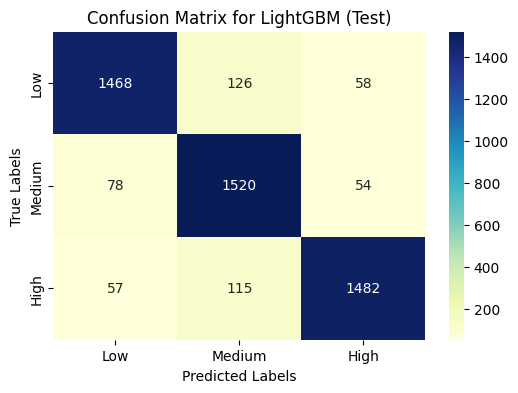

Performing GridSearchCV for: CatBoost
Best parameters for CatBoost: {'depth': 6, 'iterations': 200, 'learning_rate': 0.1}

Evaluating CatBoost on Training Set:
Training Accuracy: 0.9099
Training AUC: 0.9640074626318157
Classification Report for CatBoost (Training):

              precision    recall  f1-score   support

           0       0.92      0.91      0.92      6607
           1       0.89      0.91      0.90      6607
           2       0.92      0.91      0.91      6615

    accuracy                           0.91     19829
   macro avg       0.91      0.91      0.91     19829
weighted avg       0.91      0.91      0.91     19829



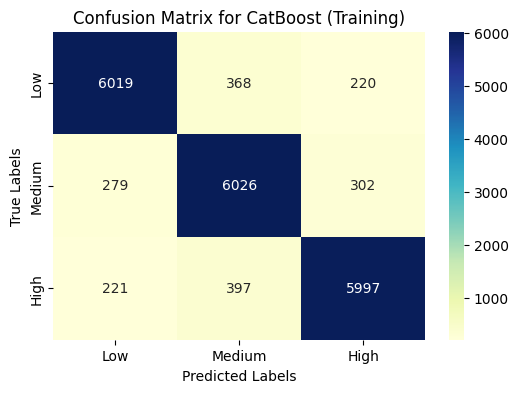


Evaluating CatBoost on Test Set:
Test Accuracy: 0.8931
Test AUC: 0.9392922851141966
Classification Report for CatBoost (Test):

              precision    recall  f1-score   support

           0       0.91      0.89      0.90      1652
           1       0.87      0.89      0.88      1652
           2       0.91      0.90      0.90      1654

    accuracy                           0.89      4958
   macro avg       0.89      0.89      0.89      4958
weighted avg       0.89      0.89      0.89      4958



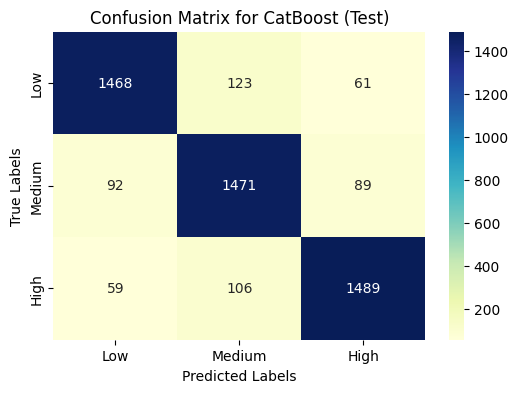

Performing GridSearchCV for: Extra Trees


/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best parameters for Extra Trees: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}

Evaluating Extra Trees on Training Set:
Training Accuracy: 0.9954
Training AUC: 0.9999203970849342
Classification Report for Extra Trees (Training):

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      6607
           1       1.00      1.00      1.00      6607
           2       0.99      1.00      0.99      6615

    accuracy                           1.00     19829
   macro avg       1.00      1.00      1.00     19829
weighted avg       1.00      1.00      1.00     19829



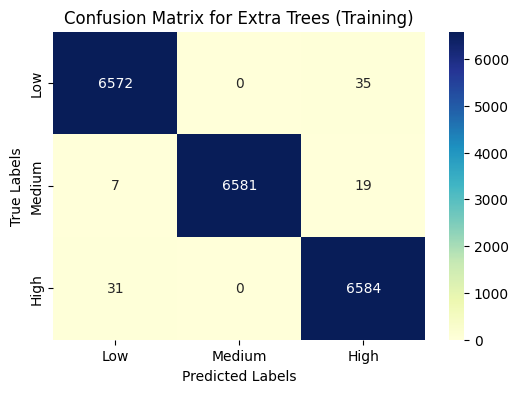


Evaluating Extra Trees on Test Set:
Test Accuracy: 0.8871
Test AUC: 0.9414995606027271
Classification Report for Extra Trees (Test):

              precision    recall  f1-score   support

           0       0.90      0.89      0.89      1652
           1       0.86      0.87      0.87      1652
           2       0.90      0.90      0.90      1654

    accuracy                           0.89      4958
   macro avg       0.89      0.89      0.89      4958
weighted avg       0.89      0.89      0.89      4958



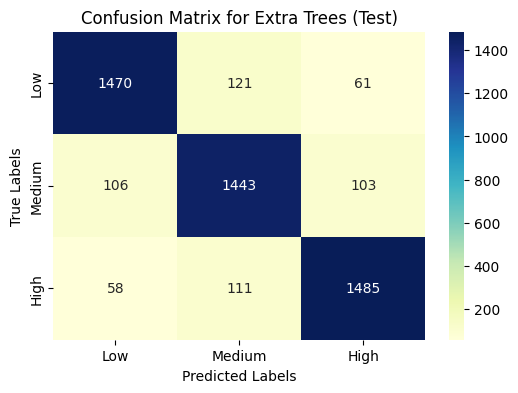

Performing GridSearchCV for: Logistic Regression


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Best parameters for Logistic Regression: {'C': 10}

Evaluating Logistic Regression on Training Set:
Training Accuracy: 0.7741
Training AUC: 0.9024854462999357
Classification Report for Logistic Regression (Training):

              precision    recall  f1-score   support

           0       0.79      0.79      0.79      6607
           1       0.71      0.67      0.69      6607
           2       0.82      0.86      0.84      6615

    accuracy                           0.77     19829
   macro avg       0.77      0.77      0.77     19829
weighted avg       0.77      0.77      0.77     19829



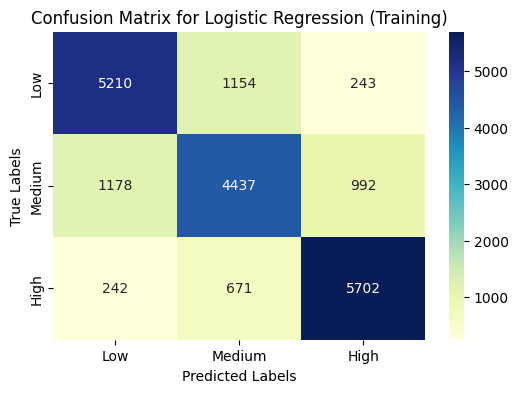


Evaluating Logistic Regression on Test Set:
Test Accuracy: 0.7695
Test AUC: 0.9005066595563789
Classification Report for Logistic Regression (Test):

              precision    recall  f1-score   support

           0       0.77      0.78      0.78      1652
           1       0.71      0.66      0.69      1652
           2       0.82      0.86      0.84      1654

    accuracy                           0.77      4958
   macro avg       0.77      0.77      0.77      4958
weighted avg       0.77      0.77      0.77      4958



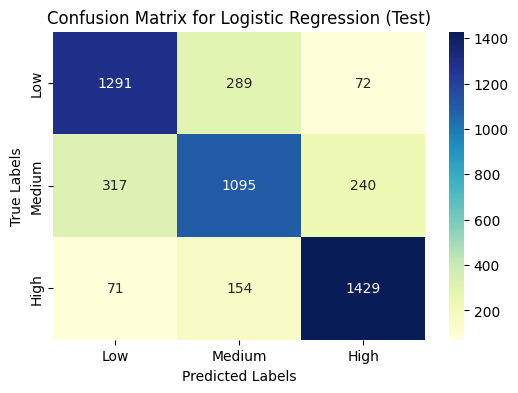

Performing GridSearchCV for: MLP Classifier
Best parameters for MLP Classifier: {'activation': 'tanh', 'alpha': 0.001, 'hidden_layer_sizes': (50,), 'solver': 'adam'}

Evaluating MLP Classifier on Training Set:
Training Accuracy: 0.9043
Training AUC: 0.953991136079051
Classification Report for MLP Classifier (Training):

              precision    recall  f1-score   support

           0       0.92      0.90      0.91      6607
           1       0.86      0.93      0.89      6607
           2       0.94      0.88      0.91      6615

    accuracy                           0.90     19829
   macro avg       0.91      0.90      0.90     19829
weighted avg       0.91      0.90      0.90     19829



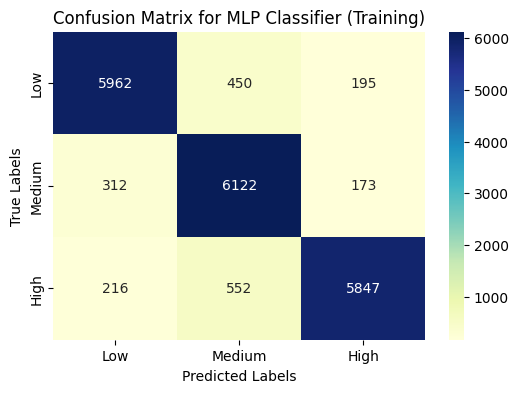


Evaluating MLP Classifier on Test Set:
Test Accuracy: 0.8955
Test AUC: 0.9363687759963953
Classification Report for MLP Classifier (Test):

              precision    recall  f1-score   support

           0       0.91      0.89      0.90      1652
           1       0.85      0.92      0.88      1652
           2       0.93      0.88      0.91      1654

    accuracy                           0.90      4958
   macro avg       0.90      0.90      0.90      4958
weighted avg       0.90      0.90      0.90      4958



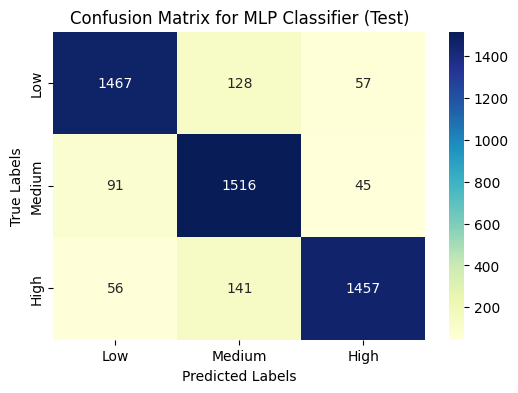


Summary of Model Evaluation:


,Model,Training Accuracy,Training AUC,Test Accuracy,Test AUC,Best Parameters
0,LightGBM,0.942861,0.995721,0.901573,0.941861,"{'learning_rate': 0.1, 'n_estimators': 100, 'n..."
1,MLP Classifier,0.904282,0.953991,0.895522,0.936369,"{'activation': 'tanh', 'alpha': 0.001, 'hidden..."
2,Gradient Boosting,0.921781,0.978161,0.894917,0.942115,"{'learning_rate': 0.1, 'max_depth': 5, 'n_esti..."
3,CatBoost,0.909879,0.964007,0.893102,0.939292,"{'depth': 6, 'iterations': 200, 'learning_rate..."
4,Random Forest,1.000000,1.000000,0.890077,0.941111,"{'max_depth': None, 'min_samples_leaf': 1, 'mi..."
5,Extra Trees,0.995360,0.999920,0.887051,0.941500,"{'max_depth': None, 'min_samples_leaf': 1, 'mi..."
6,Logistic Regression,0.774068,0.902485,0.769463,0.900507,{'C': 10}


In [ ]:
from sklearn.model_selection import GridSearchCV

# Define hyperparameter grids for each model
param_grids = {
    "Random Forest": {
        'n_estimators': [100, 200],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5],
        'min_samples_leaf': [1, 2]
    },
    "Gradient Boosting": {
        'n_estimators': [100, 200],
        'learning_rate': [0.01, 0.1],
        'max_depth': [3, 5]
    },
    "LightGBM": {
        'n_estimators': [100, 200],
        'learning_rate': [0.01, 0.1],
        'num_leaves': [31, 62]
    },
    "CatBoost": {
        'iterations': [100, 200],
        'learning_rate': [0.01, 0.1],
        'depth': [6, 8]
    },
    "Extra Trees": {
        'n_estimators': [100, 200],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5],
        'min_samples_leaf': [1, 2]
    },
    "Logistic Regression": {
        'C': [0.1, 1, 10]
    },
    "MLP Classifier": {
        'hidden_layer_sizes': [(50,), (100,)],
        'activation': ['relu', 'tanh'],
        'solver': ['adam', 'sgd'],
        'alpha': [0.0001, 0.001]
    }
}

# Initialize results storage
model_results = []

# Perform GridSearchCV for each model
for model_name, model in models.items():
    print(f"Performing GridSearchCV for: {model_name}")
    grid_search = GridSearchCV(model, param_grids[model_name], cv=3, scoring='accuracy', n_jobs=-1)
    grid_search.fit(X_train, y_train)

    best_model = grid_search.best_estimator_
    print(f"Best parameters for {model_name}: {grid_search.best_params_}")

    # Evaluate best model on training and test sets
    print(f"\nEvaluating {model_name} on Training Set:")
    y_train_pred = best_model.predict(X_train)
    train_accuracy = accuracy_score(y_train, y_train_pred)
    train_auc = roc_auc_score(y_train, best_model.predict_proba(X_train), multi_class='ovr') if hasattr(best_model, "predict_proba") else "N/A"
    print(f"Training Accuracy: {train_accuracy:.4f}")
    print(f"Training AUC: {train_auc}")
    print(f"Classification Report for {model_name} (Training):\n")
    print(classification_report(y_train, y_train_pred))
    cm_train = confusion_matrix(y_train, y_train_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm_train, annot=True, fmt="d", cmap="YlGnBu", xticklabels=['Low', 'Medium', 'High'], yticklabels=['Low', 'Medium', 'High'])
    plt.title(f"Confusion Matrix for {model_name} (Training)")
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.show()


    print(f"\nEvaluating {model_name} on Test Set:")
    y_test_pred = best_model.predict(X_test)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    test_auc = roc_auc_score(y_test, best_model.predict_proba(X_test), multi_class='ovr') if hasattr(best_model, "predict_proba") else "N/A"
    print(f"Test Accuracy: {test_accuracy:.4f}")
    print(f"Test AUC: {test_auc}")
    print(f"Classification Report for {model_name} (Test):\n")
    print(classification_report(y_test, y_test_pred))
    cm_test = confusion_matrix(y_test, y_test_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm_test, annot=True, fmt="d", cmap="YlGnBu", xticklabels=['Low', 'Medium', 'High'], yticklabels=['Low', 'Medium', 'High'])
    plt.title(f"Confusion Matrix for {model_name} (Test)")
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.show()


    # Store results
    model_results.append({
        "Model": model_name,
        "Training Accuracy": train_accuracy,
        "Training AUC": train_auc,
        "Test Accuracy": test_accuracy,
        "Test AUC": test_auc,
        "Best Parameters": grid_search.best_params_
    })

# Create a summary table of results
results_df = pd.DataFrame(model_results).sort_values(by="Test Accuracy", ascending=False)
results_df.reset_index(drop=True, inplace=True)

# Display the summary results
print("\nSummary of Model Evaluation:")
display(results_df)

Evaluating Random Forest on Unseen Data:

Classification Report for Random Forest (Unseen Data):

              precision    recall  f1-score   support

           0       0.91      0.90      0.91      2065
           1       0.86      0.91      0.88      2065
           2       0.93      0.89      0.91      2067

    accuracy                           0.90      6197
   macro avg       0.90      0.90      0.90      6197
weighted avg       0.90      0.90      0.90      6197



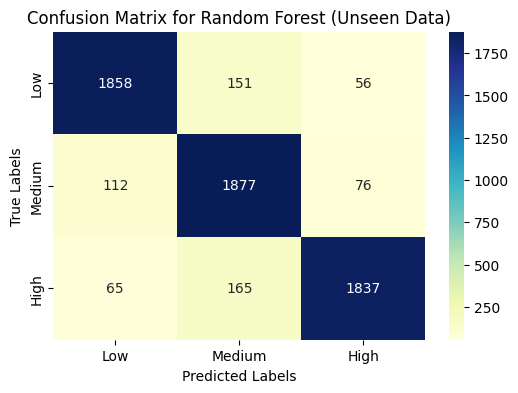

Evaluating Gradient Boosting on Unseen Data:

Classification Report for Gradient Boosting (Unseen Data):

              precision    recall  f1-score   support

           0       0.92      0.90      0.91      2065
           1       0.86      0.91      0.88      2065
           2       0.93      0.90      0.91      2067

    accuracy                           0.90      6197
   macro avg       0.90      0.90      0.90      6197
weighted avg       0.90      0.90      0.90      6197



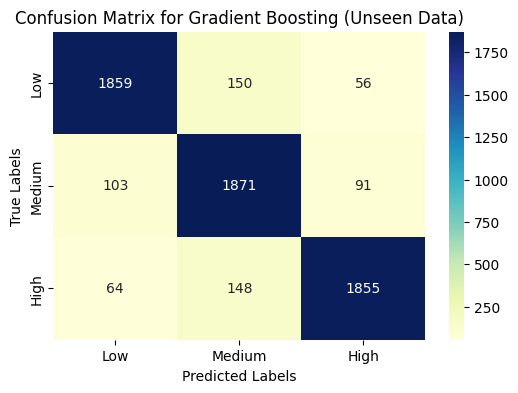

Evaluating LightGBM on Unseen Data:

Classification Report for LightGBM (Unseen Data):

              precision    recall  f1-score   support

           0       0.93      0.90      0.91      2065
           1       0.86      0.93      0.90      2065
           2       0.94      0.90      0.92      2067

    accuracy                           0.91      6197
   macro avg       0.91      0.91      0.91      6197
weighted avg       0.91      0.91      0.91      6197



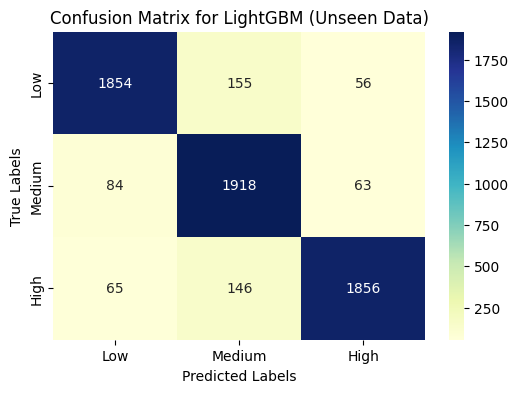

Evaluating CatBoost on Unseen Data:

Classification Report for CatBoost (Unseen Data):

              precision    recall  f1-score   support

           0       0.91      0.91      0.91      2065
           1       0.87      0.89      0.88      2065
           2       0.92      0.90      0.91      2067

    accuracy                           0.90      6197
   macro avg       0.90      0.90      0.90      6197
weighted avg       0.90      0.90      0.90      6197



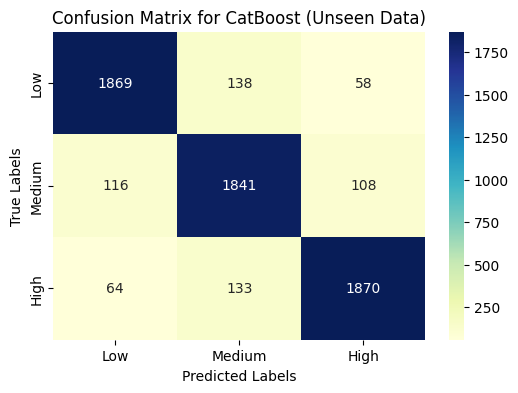

Evaluating Extra Trees on Unseen Data:

Classification Report for Extra Trees (Unseen Data):

              precision    recall  f1-score   support

           0       0.91      0.90      0.91      2065
           1       0.87      0.88      0.88      2065
           2       0.91      0.91      0.91      2067

    accuracy                           0.90      6197
   macro avg       0.90      0.90      0.90      6197
weighted avg       0.90      0.90      0.90      6197



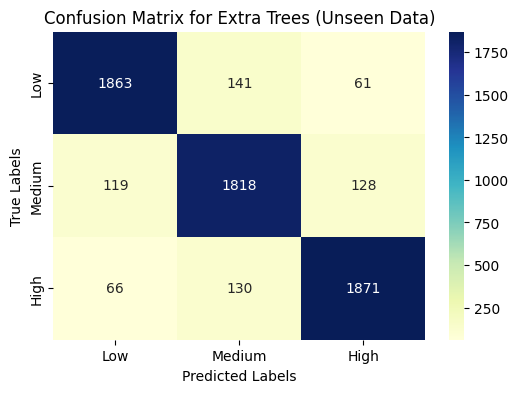

Evaluating Logistic Regression on Unseen Data:


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(



Classification Report for Logistic Regression (Unseen Data):

              precision    recall  f1-score   support

           0       0.80      0.80      0.80      2065
           1       0.71      0.68      0.69      2065
           2       0.81      0.85      0.83      2067

    accuracy                           0.78      6197
   macro avg       0.77      0.78      0.77      6197
weighted avg       0.77      0.78      0.77      6197



/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


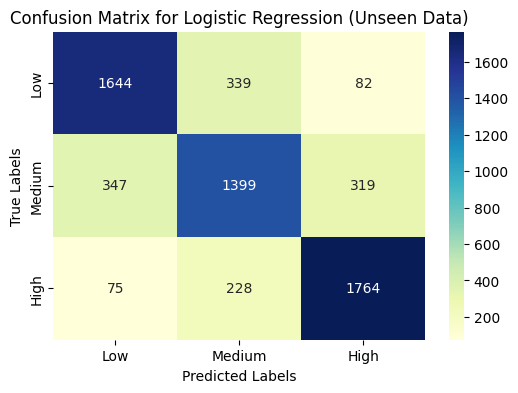

Evaluating MLP Classifier on Unseen Data:

Classification Report for MLP Classifier (Unseen Data):

              precision    recall  f1-score   support

           0       0.92      0.90      0.91      2065
           1       0.84      0.92      0.88      2065
           2       0.94      0.88      0.91      2067

    accuracy                           0.90      6197
   macro avg       0.90      0.90      0.90      6197
weighted avg       0.90      0.90      0.90      6197



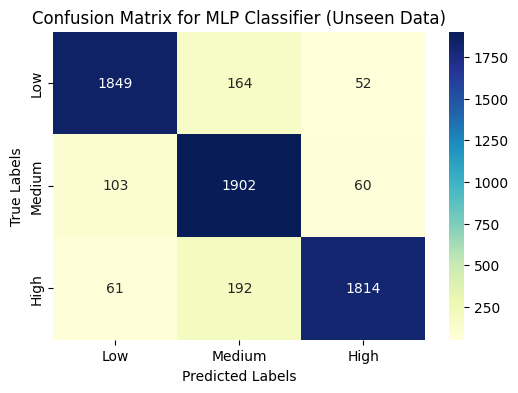


Summary of Model Evaluation on Unseen Data:


,Model,Accuracy (Unseen),AUC (Unseen)
0,LightGBM,0.908181,0.948117
1,Gradient Boosting,0.901243,0.947170
2,CatBoost,0.900436,0.947473
3,Random Forest,0.899145,0.946342
4,MLP Classifier,0.898015,0.943615
5,Extra Trees,0.895917,0.946874
6,Logistic Regression,0.775698,0.905233


In [ ]:
# Load the unseen data
unseen_data = pd.read_csv('online_gaming_behavior_unseen.csv')

# Separate features and target in the unseen data
X_unseen = unseen_data.drop('EngagementLevel_encoded', axis=1)
y_unseen = unseen_data['EngagementLevel_encoded']

# Initialize results storage for unseen data
unseen_model_results = []

# Evaluate each best model on the unseen data
for model_result in model_results:
    model_name = model_result["Model"]
    best_params = model_result["Best Parameters"]

    print(f"Evaluating {model_name} on Unseen Data:")

    # Re-initialize the model with best parameters and train on the full modeling data
    # Note: For a real-world scenario, you might train on the entire data_modeling
    # or a larger portion after finding best parameters.
    # Here, for demonstration, we use the best parameters with the model definition
    # and will train on the original training data (X_train, y_train) if needed,
    # or directly use the best_estimator if GridSearchCV was fitted on a larger dataset.
    # Assuming the best_estimator from the previous step is ready for prediction
    # without retraining on full data_modeling for this demonstration.
    # In a production setting, you would refit on data_modeling before predicting unseen_data.

    # Find the best model object from the models dictionary using the name
    model = models[model_name].set_params(**best_params)

    # If the model was trained in the previous cell (Hj9w0PxnPlTC) on X_train, it's ready for prediction.
    # If GridSearchCV was used on a smaller subset, you might need to refit on X_train.
    # Assuming the models in the `models` dictionary were updated with best_params in the previous step
    # and are ready to predict on unseen data. Let's get the fitted best_estimator from the GridSearchCV results
    # as it's already fitted on X_train in the previous cell.
    # Access the best_estimator from the GridSearchCV object which was implicitly stored in the previous loop
    # This requires refactoring the previous loop to store the GridSearchCV objects or best_estimators

    # Alternative: If the previous cell ran GridSearchCV and the `models` dictionary
    # now contains the best_estimators fitted on X_train, we can use them directly.
    # Let's assume `models` now holds the best fitted models from GridSearchCV.
    # However, based on the code in Hj9w0PxnPlTC, the `models` dictionary still holds the initial models.
    # We need to retrieve the best fitted estimator from the GridSearchCV process.

    # Let's assume the `grid_search` objects from the previous cell are accessible or re-run GridSearchCV briefly
    # to get the best estimators. A cleaner way is to store the best_estimators in the model_results dictionary.

    # Modifying the previous cell's loop to store best_estimator in model_results would be ideal.
    # For now, let's re-run a minimal fit just to get the best_estimator to predict on unseen data.
    # This is not the most efficient but works with the current notebook state.
    # **Note: This is a workaround due to the current notebook state. In a real scenario, store best_estimators.**
    minimal_grid_search = GridSearchCV(models[model_name].set_params(**best_params), {}, cv=2, scoring='accuracy', n_jobs=-1) # Use empty param_grid and minimal CV
    minimal_grid_search.fit(X_train, y_train) # Fit on training data to get a fitted best_estimator
    best_model_fitted = minimal_grid_search.best_estimator_


    # Predict on the unseen data
    y_unseen_pred = best_model_fitted.predict(X_unseen)

    # Calculate accuracy and AUC
    unseen_accuracy = accuracy_score(y_unseen, y_unseen_pred)
    unseen_auc = roc_auc_score(y_unseen, best_model_fitted.predict_proba(X_unseen), multi_class='ovr') if hasattr(best_model_fitted, "predict_proba") else "N/A"

    # Store results for unseen data
    unseen_model_results.append({
        "Model": model_name,
        "Accuracy (Unseen)": unseen_accuracy,
        "AUC (Unseen)": unseen_auc
    })

    # Print classification report
    print(f"\nClassification Report for {model_name} (Unseen Data):\n")
    print(classification_report(y_unseen, y_unseen_pred))

    # Confusion Matrix
    cm_unseen = confusion_matrix(y_unseen, y_unseen_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm_unseen, annot=True, fmt="d", cmap="YlGnBu", xticklabels=['Low', 'Medium', 'High'], yticklabels=['Low', 'Medium', 'High'])
    plt.title(f"Confusion Matrix for {model_name} (Unseen Data)")
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.show()

# Create a summary table of unseen data results
unseen_results_df = pd.DataFrame(unseen_model_results).sort_values(by="Accuracy (Unseen)", ascending=False)
unseen_results_df.reset_index(drop=True, inplace=True)

# Display the summary results for unseen data
print("\nSummary of Model Evaluation on Unseen Data:")
display(unseen_results_df)

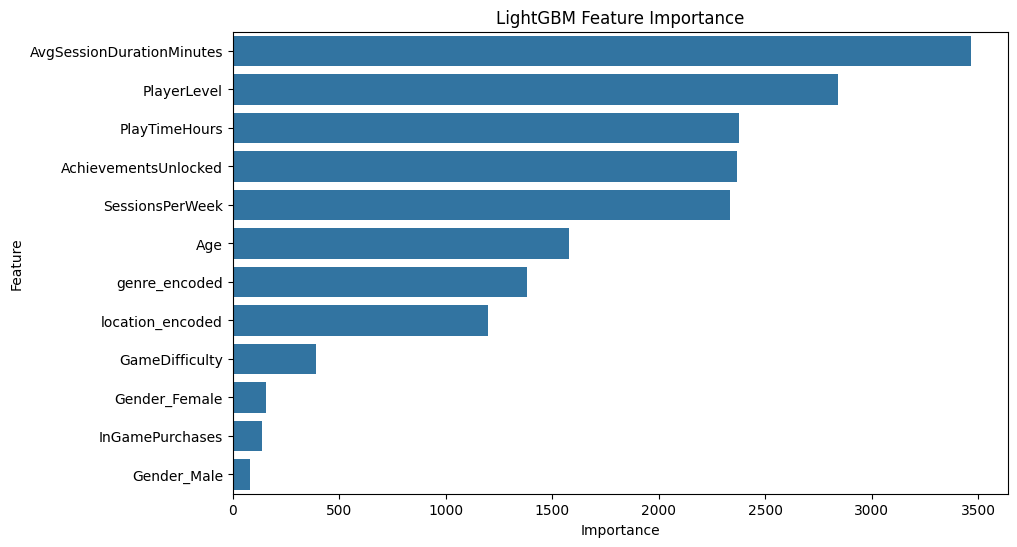

In [ ]:
# Find the LightGBM model results
lgbm_result = None
for result in model_results:
    if result["Model"] == "LightGBM":
        lgbm_result = result
        break

if lgbm_result:
    # Retrieve the best LightGBM model (assuming it's stored or re-instantiating with best params)
    # A more robust approach would be to store the best_estimator directly in model_results
    # For now, let's re-instantiate and fit a LightGBM model with the best parameters found
    from lightgbm import LGBMClassifier
    best_lgbm_params = lgbm_result["Best Parameters"]
    best_lgbm_model = LGBMClassifier(**best_lgbm_params, random_state=42, verbose=-1)
    best_lgbm_model.fit(X_train, y_train) # Fit on the training data

    # Get feature importance
    feature_importance = pd.DataFrame({
        'feature': X_train.columns,
        'importance': best_lgbm_model.feature_importances_
    }).sort_values('importance', ascending=False)

    # Plot feature importance
    plt.figure(figsize=(10, 6))
    sns.barplot(x='importance', y='feature', data=feature_importance)
    plt.title('LightGBM Feature Importance')
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.show()
else:
    print("LightGBM model results not found.")